# Task 2 Classification on the Telco-churn dataset

## Yawen Han (yh3069)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


In [2]:
#load dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Preprocess tha data

In [3]:
#as customer ID is only a identifier, treat it as the index
#to avoid the onhot-encoding later
df=df.set_index("customerID")
#change two columns datatype: "TotalCharges", "SeniorCitizen"
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')
df["SeniorCitizen"] = df["SeniorCitizen"].astype(str)


As "customerID" is only a identifier with no contributing to the target, treat it as the index of the dataframe to avoid the onhot-encoding later. Change the feature "TotalCharges" to numerical datatype, and feature "SeniorCitizen" to categorical datatype for data explorations later.

## Question 2.1

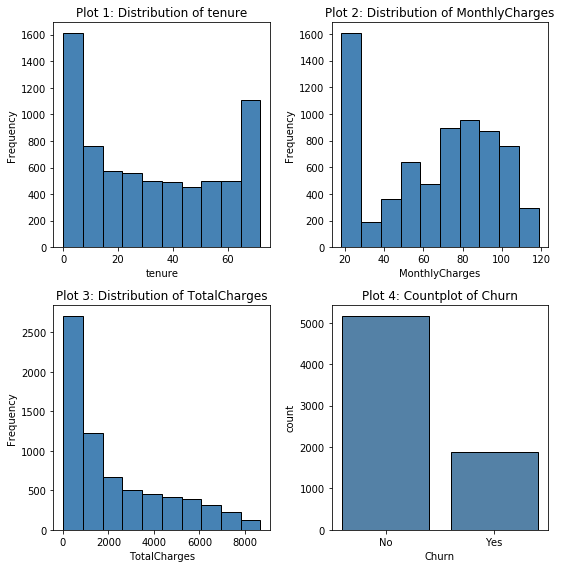

In [4]:
import seaborn as sns

# univariate distribution plots
fig = plt.figure(figsize=(8,8))
count = 1
for i,column in enumerate(df.columns):
    #plot the histogram of all columns that are not object datatype
    if df.dtypes[column] != np.object:
        ax = fig.add_subplot(2, 2, count)
        ax.set_title("Plot %d: Distribution of %s" %(count,column))
        ax.set_xlabel(column)
        ax.set_ylabel("Frequency")
        ax.hist(df[column], edgecolor='black',bins=10,color="steelblue")
        #count for subplot
        count+=1
    #count plot for target
    if column == "Churn":
        ax = fig.add_subplot(2, 2, count)
        sns.countplot(df["Churn"],axes=ax,color="steelblue",edgecolor='black')
        ax.set_title("Plot %d: Countplot of %s" %(count,column))

_ = plt.tight_layout()
plt.show()

Plot 1~3 shows the distribution of each continuous features (**features that not a "object" datatype are considered to be continuous**). Plot 4 shows the distribution of the target-"Churn".

## Question 2.2

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

X = df.iloc[:,:-1]#features
y = df.iloc[:,-1]#target-SalePrice
#split data in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y)


In [6]:
#find categorical and numerical features
categorical_features = X_train.loc[:,X_train.dtypes==np.object].columns.tolist()
numerical_features = X_train.loc[:,X_train.dtypes!=np.object].columns.tolist()

#Numerical features: handling missing value, scaler
numerical_transformer_scaled = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
#Numerical features: handling missing value
numerical_transformer_unscaled = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])
#categorical features: one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown="ignore",sparse=False))])
#column transformer: scaled numerical & categorical
preprocessor_scaled = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_scaled, numerical_features),
        ('cat', categorical_transformer, categorical_features)])
#column transformer: unscaled numerical & categorical
preprocessor_unscaled = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_unscaled, numerical_features),
        ('cat', categorical_transformer, categorical_features)])


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestCentroid
import warnings
warnings.filterwarnings("ignore")


#build Logistic Regression model
lr_model_scaled = Pipeline(steps=[('preprocessor_scaled', preprocessor_scaled),('lr', LogisticRegression())])
lr_model_unscaled = Pipeline(steps=[('preprocessor_unscaled', preprocessor_unscaled),('lr', LogisticRegression())])
#build Linear SVM model
svm_model_scaled = Pipeline(steps=[('preprocessor_scaled', preprocessor_scaled),('svm', LinearSVC())])
svm_model_unscaled = Pipeline(steps=[('preprocessor_unscaled', preprocessor_unscaled),('svm', LinearSVC())])
#build Nearest Centroid model
nc_model_scaled = Pipeline(steps=[('preprocessor_scaled', preprocessor_scaled),('nc', NearestCentroid())])
nc_model_unscaled = Pipeline(steps=[('preprocessor_unscaled', preprocessor_unscaled),('nc', NearestCentroid())])


In [8]:
#Logistic Regression:compute scaled/unscaled scores
lr_scores_scaled = cross_val_score(lr_model_scaled, X_train, y_train)
lr_scores_unscaled = cross_val_score(lr_model_unscaled, X_train, y_train)
#Linear SVM:compute scaled/unscaled scores
svm_scores_scaled = cross_val_score(svm_model_scaled, X_train, y_train)
svm_scores_unscaled = cross_val_score(svm_model_unscaled, X_train, y_train)
#Nearest Centroid:compute scaled/unscaled scores
nc_scores_scaled = cross_val_score(nc_model_scaled, X_train, y_train)
nc_scores_unscaled = cross_val_score(nc_model_unscaled, X_train, y_train)


In [9]:
#show the mean scaled/unscaled score as a table
scores = [['Scaled',np.mean(lr_scores_scaled),np.mean(svm_scores_scaled),np.mean(nc_scores_scaled)],
        ['Unscaled',np.mean(lr_scores_unscaled),np.mean(svm_scores_unscaled),np.mean(nc_scores_unscaled)]]
df_scores = pd.DataFrame(scores,columns=['Option','LogisticRegression','LinearSVM','NearestCentroids'])
df_scores.set_index("Option")

,LogisticRegression,LinearSVM,NearestCentroids
Option,,,
Scaled,0.808405,0.808595,0.735515
Unscaled,0.810488,0.762018,0.517228


From the table above, it is observed that the **Scaled** models has a higher cross-validation score compared to unscaled models. The "Linear Support Vector Machine" and "Nearest Centroids" have a great improvement on the score performence, while "Logistic Regression" does not have an obvious change on the score.

## Question 2.3

In [10]:
from sklearn.model_selection import GridSearchCV

#scaled X_train data
fit_scaled = preprocessor_scaled.fit(X_train)
X_scaled = fit_scaled.transform(X_train)
#choice/range of C/shrink_threshold parameter
c = np.logspace(-1,2,num=30)
param_grid=[{'C': c},{'C': c},{'shrink_threshold': c}]

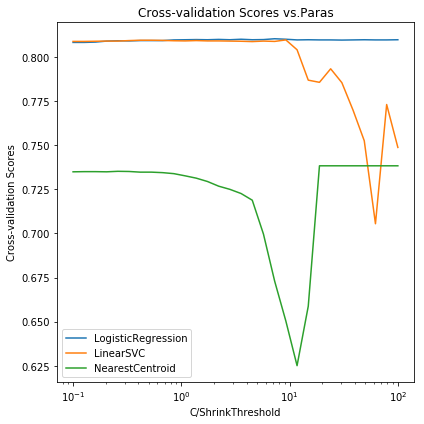

In [11]:
coefficients = []
#plot Score vs. params
fig = plt.figure(figsize=(6,6))
count = 0
models = [LogisticRegression(),LinearSVC(),NearestCentroid()]
model_name = ["LogisticRegression","LinearSVC","NearestCentroid"]
para = ["C","C","Shrink Threshold"]
#GridSearch the parameters for three models
for model in models:
    grid = GridSearchCV(model,param_grid=param_grid[count])
    grid.fit(X_scaled, y_train)
    #gridserach results
    results = grid.cv_results_
    plt.plot(c, results["mean_train_score"],label=model_name[count])
    plt.xscale("log")
    count += 1
    #only store the coefficients for LogisticRegression and Linear SVM
    if count < 3:
        #best model coefficients 
        coefficients.append(grid.best_estimator_.coef_)        
plt.title("Cross-validation Scores vs.Paras")
plt.xlabel("C/ShrinkThreshold")
plt.ylabel("Cross-validation Scores")        
plt.tight_layout()
plt.legend()
plt.show()

Tune the parameter for all three models using the sclaed dataset we got from Question 2.2: 
1. The cross-validation score of "Logistic Regression" model do not have obvious change when tuning the parameter C.It always has a high score;
2. The cross-validation score of "Linear Support Vector Machine" model do not have obvious change when the tuning parameter C smaller than 10, but it decreases as C grows when C greater than 10;
3. The cross-validation score of "Nearest Centroid" model decrease as the tuning parameter ShrinkThreshold grows when smaller than 10, but it increase back as ShrinkThreshold grows when greater than 10.

## Question 2.4

In [12]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [13]:
#define a function compare_param that gridsearch params for all three models
#then output the best parameters for three models
def compare_param(cv):
    best_para = []
    #Gridsearch the parameters for all three models
    for (i,model) in enumerate(models):
        grid = GridSearchCV(model,param_grid=param_grid[i],cv=cv)
        grid.fit(X_scaled, y_train)
        #gridserach results-best parameter
        best_para.append(grid.best_params_)
    return best_para
    


In [14]:
#best params of three models for (KFold,random_state=0)
kf_rs0 = compare_param(cv=KFold(n_splits=5,shuffle=True,random_state=0)) 
#best params of three models for (KFold,random_state=1)
kf_rs1 = compare_param(cv=KFold(n_splits=5,shuffle=True,random_state=1)) 
#best params of three models for (StratifiedKFold,random_state=0)
skf_rs0 = compare_param(cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)) 
#best params of three models for (StratifiedKFold,random_state=1)
skf_rs1 = compare_param(cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=1)) 


In [15]:
#define function best_para that show the best_parameter matrix
#for the given model
def best_para(model_index,parameter):
    
    #show the mean scaled/unscaled score as a table
    best_para_df = [['KFold',kf_rs0[model_index][parameter],kf_rs1[model_index][parameter]],
        ['StratifiedKFold',skf_rs0[model_index][parameter],skf_rs1[model_index][parameter]]]
    best_para_df = pd.DataFrame(best_para_df,columns=['%s: %s'%(model_name[model_index],para[model_index]),'RandomState=0','RandomState=1'])
    best_para_df = best_para_df.set_index('%s: %s'%(model_name[model_index],para[model_index]))
    return best_para_df


In [16]:
#Logistic Regression Model: best parameter C 
#for differnet split method and random-state
best_para(0,"C")

,RandomState=0,RandomState=1
LogisticRegression: C,,
KFold,23.950266,0.259294
StratifiedKFold,18.873918,0.259294


Logistic Regression model:
1. change cv strategy from "StratifiedKFold" to "KFold", the best paramenter C are found change;
2. change the reandom state from 0 to 1, the best parameter C are also found change.

In [17]:
#Linear SVM Model: best parameter C 
#for differnet split method and random-state
best_para(1,"C")

,RandomState=0,RandomState=1
LinearSVC: C,,
KFold,0.204336,4.520354
StratifiedKFold,7.278954,7.278954


Linear SVM model:
1. change cv strategy from "StratifiedKFold" to "KFold", the best paramenter C are found change;
2. change the reandom state from 0 to 1, the best parameter C are also found change.

In [18]:
#Nearest Centroid Model: best parameter shrink_threshold 
#for differnet split method and random-state
best_para(2,"shrink_threshold")

,RandomState=0,RandomState=1
NearestCentroid: Shrink Threshold,,
KFold,18.873918,18.873918
StratifiedKFold,18.873918,18.873918


Nearest Centroid model:
1. change cv strategy from "StratifiedKFold" to "KFold", the best paramenter shrink_threshold are not observed obvious change;
2. change the reandom state from 0 to 1, the best paramenter shrink_threshold are not observed obvious change.

## Question 2.5

In [19]:
#get the categorical column names after one-hot encoding
#temp one-hot encoding used for finding column names
preprocessor = ColumnTransformer(transformers=[('onehot', OneHotEncoder(handle_unknown="ignore"), 
                                                categorical_features)])
catg_ohe = preprocessor.fit(X_train).get_feature_names()
catg_ohe = pd.DataFrame(catg_ohe)
#remove the prefix "onehot_"
catg_ohe = catg_ohe.applymap(lambda x: str(x).lstrip("onehot_"))
#replace prefix "x0,x1,x2..." as original column names
for (i,name) in enumerate(categorical_features):
    catg_ohe = catg_ohe.applymap(lambda x: str(x).replace("x"+str(i),name))

#the feature name list contaning all feature names 
ohe_feature_names = numerical_features + catg_ohe.iloc[:,0].tolist()


In [20]:
#define plot_scatter function to plot feature coefficients vs. feature index
def plot_scatter(i):
    ax = fig.add_subplot(2, 2, 2*i+1)
    ax.scatter(range(len(coefficients[0][0])), coefficients[i][0],c=np.sign(coefficients[i][0]), cmap="bwr_r",alpha=0.5)
    ax.set_title("%s: Coefficients vs. Features"%model_name[i])
    ax.set_xlabel("Features")
    ax.set_ylabel("Coefficients")
    ax.ticklabel_format(axis='y', style='sci',scilimits=(-2,2))

In [21]:
#define plot_barh function to plot top10 absolute coefficients feature values
def plot_barh(i):
    ax = fig.add_subplot(2, 2, 2*i+2)
    top10 = sorted([(abs(x),j) for (j,x) in enumerate(coefficients[i][0])],reverse=True)[:10]
    val = []
    top10_columns = []
    for x in top10:    
        #top10 coefficients
        val.append(coefficients[i][0][x[1]])
        #top10 column names
        top10_columns.append(ohe_feature_names[x[1]])
    #plot the top10coefficients horizontally
    ax.barh(top10_columns[::-1],val[::-1])
    ax.set_title("%s: Top10 Important Features"%model_name[i])
    ax.set_xlabel("Coefficients")
    ax.ticklabel_format(axis='x', style='sci',scilimits=(-2,2))
    

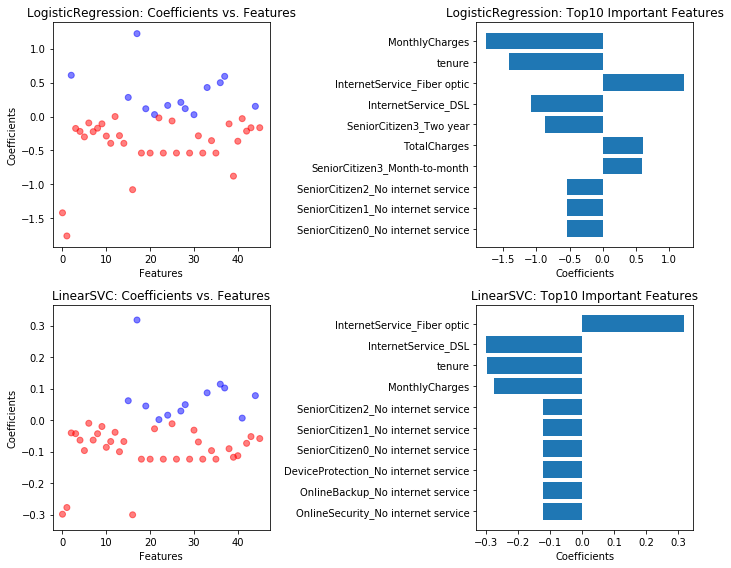

In [22]:
#plot scatterplots on left, bar charts on right for two models
fig = plt.figure(figsize=(10,8))
for i in range(2):
    plot_scatter(i)
    plot_barh(i)
plt.tight_layout()
plt.show()

The scatter plots on the left shows the coefficients of each feature vs. their feature index. The horizontal bar charts on the right shows the top 10 features with absolute coefficients.

Compared two scatter plots and bar plots above, "Logistic Regression" and "Linear SVC" have similar coefficients distribution, indicating they have some agreement on the coefficients importance. 